In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Load the dataset into a pandas DataFrame
file_path = 'bugs-train.csv'
eencoding = detect_encoding(file_path)
df = pd.read_csv(file_path, encoding = eencoding)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159998 entries, 0 to 159997
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   bug_id    159998 non-null  int64 
 1   summary   159998 non-null  object
 2   severity  159998 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [ ]:
df.describe()

,bug_id
count,1.599980e+05
mean,7.482937e+05
std,2.220960e+05
min,3.655690e+05
25%,5.609778e+05
50%,7.502555e+05
75%,9.332742e+05
max,1.143398e+06


In [ ]:
df.head()

,bug_id,summary,severity
0,365569,Remove workaround from bug 297227,normal
1,365578,Print Preview crashes on any URL in gtk2 builds,critical
2,365582,Lines are not showing in table,major
3,365584,Firefox render ÛÏsimplified ArabicÛ font fa...,normal
4,365597,Crash [@ nsINodeInfo::NodeInfoManager],critical


In [ ]:
# Check for missing values in each column
df.isnull().sum()

bug_id      0
summary     0
severity    0
dtype: int64

In [ ]:
df['severity'].value_counts()

severity
normal         125854
critical        18658
major            6053
enhancement      4426
minor            3102
trivial          1204
blocker           701
Name: count, dtype: int64

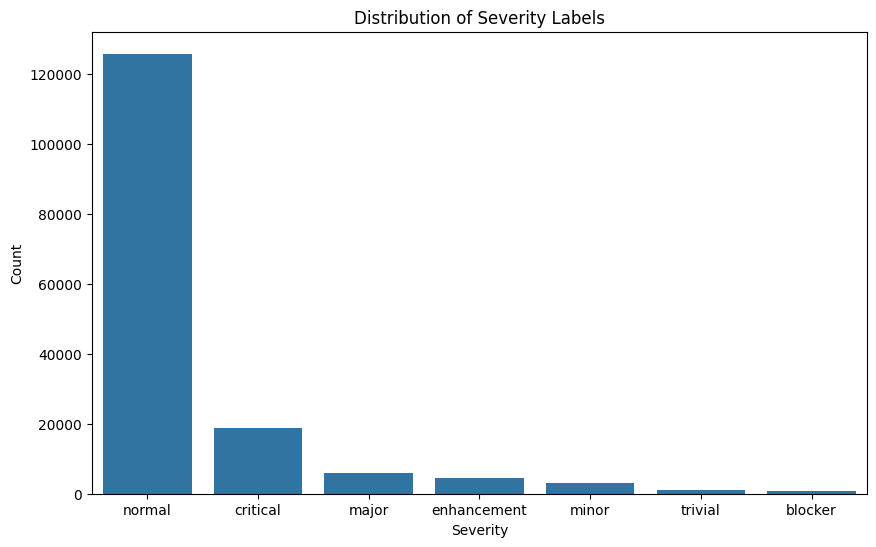

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='severity', data=df, order=df['severity'].value_counts().index)
plt.title('Distribution of Severity Labels')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

In [ ]:
# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    text = ' '.join(word for word in words if word not in stop_words)
    return text

In [ ]:
df

,bug_id,summary,severity
0,365569,Remove workaround from bug 297227,normal
1,365578,Print Preview crashes on any URL in gtk2 builds,critical
2,365582,Lines are not showing in table,major
3,365584,Firefox render ÛÏsimplified ArabicÛ font fa...,normal
4,365597,Crash [@ nsINodeInfo::NodeInfoManager],critical
...,...,...,...
159993,1143381,block elements with height after float left or...,normal
159994,1143392,typing in google translate will send reset inp...,normal
159995,1143394,[gstreamer] Nightly instantly crashes on Youtu...,critical
159996,1143395,Right click on Flash object with accessibility...,critical


In [ ]:
# Define a function for text normalization
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    text = ' '.join(word for word in words if word not in stop_words)
    return text

# Apply text normalization
df['normalized_summary'] = df['summary'].apply(normalize_text)

# Define a function for lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    lemmatized_text = ' '.join(lemmatizer.lemmatize(word) for word in words)
    return lemmatized_text

# Apply lemmatization
df['lemmatized_summary'] = df['normalized_summary'].apply(lemmatize_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Prepare the labels (severity encoded as integers)
severity_mapping = {'enhancement': 1, 'minor': 2, 'normal': 3, 'major': 4, 'blocker': 5, 'critical': 6}

df['severity_encoded'] = df['severity'].map(severity_mapping)
# Drop rows with NaN values in the target variable
df.dropna(subset=['severity_encoded'], inplace=True)

In [ ]:
# TF-IDF Representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_summary'])

In [ ]:
# Check for NaN values specifically in the 'severity' column
nan_severity = df[df['severity_encoded'].isna()]

# Display rows with NaN values in the 'severity' column
print("Rows with NaN values in 'severity' column:\n", nan_severity)

Rows with NaN values in 'severity' column:
          bug_id                                            summary severity  \
50       365832  Combobox popup is slightly too large when sele...  trivial   
83       365996  Take advantage of old yes/no constant in nsIPr...  trivial   
111      366130  "path data parse error" should not be an asser...  trivial   
339      367102                     put maps in alphabetical order  trivial   
453      367521  css attr() function doesn't urldecode tags lik...  trivial   
...         ...                                                ...      ...   
155043  1122456  CachedStatement use of mozStorageStatementScop...  trivial   
155600  1124609                This is a test of posting a new bug  trivial   
157229  1131728  Black bar appears above bookmark icon when ope...  trivial   
159239  1140362  [disabled e10s] Graphical glitch during animation  trivial   
159794  1142609  Python code in dom/bindings should follow the ...  trivial   

       

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['severity_encoded'], test_size=0.2, random_state=42)

In [ ]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Compute macro precision
macro_precision_svm = precision_score(y_test, y_pred_svm, average='macro')
print("SVM Macro Precision:", macro_precision_svm)

SVM Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.01      0.01       901
           2       0.55      0.01      0.02       630
           3       0.87      0.98      0.92     25236
           4       0.74      0.03      0.05      1203
           5       0.00      0.00      0.00       139
           6       0.81      0.75      0.78      3650

    accuracy                           0.86     31759
   macro avg       0.64      0.29      0.30     31759
weighted avg       0.85      0.86      0.82     31759

SVM Macro Precision: 0.6373792754990414


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils.validation import check_is_fitted

In [ ]:
# Load the training dataset into a pandas DataFrame
file_path = 'bugs-train.csv'
df = pd.read_csv(file_path, encoding='utf-8')  # Assuming 'utf-8' encoding

In [ ]:
# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    text = ' '.join(word for word in words if word not in stop_words)
    return text

# Apply text normalization
df['normalized_summary'] = df['summary'].apply(normalize_text)

# Define a function for lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    lemmatized_text = ' '.join(lemmatizer.lemmatize(word) for word in words)
    return lemmatized_text

# Apply lemmatization
df['lemmatized_summary'] = df['normalized_summary'].apply(lemmatize_text)

# Prepare the labels (severity encoded as integers)
severity_mapping = {'trivial' : 1,'enhancement': 2, 'minor': 3, 'normal': 4, 'major': 5, 'blocker': 6, 'critical': 7}
df['severity_encoded'] = df['severity'].map(severity_mapping)

# Drop rows with NaN values in the target variable
df.dropna(subset=['severity_encoded'], inplace=True)

# TF-IDF Representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_summary'])


KeyboardInterrupt: 

In [ ]:
# Initialize and train the SVM model on the entire dataset
svm_model = SVC(kernel='linear')
svm_model.fit(tfidf_matrix, df['severity_encoded'])

In [ ]:
# Load new data from an Excel file
new_file_path = 'bugs-test.csv'
new_df = pd.read_excel(new_file_path)

In [ ]:
# Function to preprocess new data
def preprocess_new_data(new_data):
    new_data = new_data.apply(normalize_text)
    new_data = new_data.apply(lemmatize_text)
    new_tfidf_matrix = tfidf_vectorizer.transform(new_data)
    return new_tfidf_matrix

# Function to predict severity for new data
def predict_severity(new_data):
    check_is_fitted(svm_model)
    new_tfidf_matrix = preprocess_new_data(new_data)
    severity_predictions = svm_model.predict(new_tfidf_matrix)
    severity_mapping_reverse = {v: k for k, v in severity_mapping.items()}
    severity_predictions_str = [severity_mapping_reverse[pred] for pred in severity_predictions]
    return severity_predictions_str

# Predict severity for the new data
new_df['predicted_severity'] = predict_severity(new_df['summary'])

# Save the modified DataFrame to a new Excel file
output_file_path = 'bugs-test-with-predictions.csv'
new_df.to_excel(output_file_path, index=False)

print("Predicted severity for new data and saved to", output_file_path)

svm sucks let try deep learing bert

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_score, classification_report
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Load Data
train_data = pd.read_csv('bugs-train.csv')
test_data = pd.read_csv('bugs-test.csv')

In [ ]:
# Map Severity Labels to Numbers
severity_mapping = {
    'trivial' : 1,
    'enhancement': 2,
    'minor': 3,
    'normal': 4,
    'major': 5,
    'blocker': 6,
    'critical': 7
}

In [ ]:
train_data['severity'] = train_data['severity'].map(severity_mapping)

In [ ]:
# Initialize BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Custom Dataset Class
class BugDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, include_labels=True):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_labels = include_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['summary']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {
            'summary_id': row['bug id'],
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        if self.include_labels:
            item['severity'] = torch.tensor(row['severity'], dtype=torch.long)
        return item


In [ ]:
train_dataset = BugDataset(train_data, tokenizer, max_len=128, include_labels=True)
test_dataset = BugDataset(test_data, tokenizer, max_len=128, include_labels=False)

In [ ]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Initialize BERT for Sequence Classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from transformers import TrainingArguments

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps"  # Change eval_strategy to "steps"
)



ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
# Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='macro')
    return {
        'macro_precision': precision,
    }

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,  # Using train dataset for eval due to lack of labels in test dataset
    compute_metrics=compute_metrics
)

NameError: name 'training_args' is not defined

In [ ]:
# Train Model
trainer.train()

In [ ]:
# Make Predictions on Test Data
def get_predictions(model, data_loader):
    model.eval()
    summary_ids = []
    predictions = []

    with torch.no_grad():
        for d in data_loader:
            summary_ids.extend(d['summary_id'])
            input_ids = d['input_ids'].to(model.device)
            attention_mask = d['attention_mask'].to(model.device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())

    return summary_ids, predictions

In [ ]:
summary_ids, preds = get_predictions(model, test_loader)

In [ ]:
# Save Results to CSV
results_df = pd.DataFrame({
    'summary id': summary_ids,
    'prediction label': preds
})

results_df.to_csv('bug_predictions.csv', index=False)
print("Predictions saved to bug_predictions.csv")

In [ ]:
import regex
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub('[^a-z ]+', '', w) for w in word_tokens]
    filtered_text = [regex.sub('[ ][ ]+', '', w) for w in filtered_text]
    filtered_text = [regex.sub('[0-9]', '', w) for w in filtered_text]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, 'v') for w in filtered_text if not w in stop_words and len(w) > 2 and len(w) < 50]
    return " ".join(filtered_text)

In [ ]:
df = pd.read_csv("bugs-train.csv")
df = df[df['severity'] != "trivial"] #not in the given classes
df["filtered_text"] = df["summary"].apply(lambda x : filter_text(x, stop))
df.head()

In [ ]:
df['classification'] = df['severity'].replace(['enhancement', 'minor', 'normal', 'major', 'blocker','critical'],[1,2,3,4,5,6])
df['classification'] = df['classification'].dropna()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
df['classification'].astype(int)

In [ ]:
import regex
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize WordNet lemmatizer and define English stopwords
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub('[^a-z ]+', '', w) for w in word_tokens]
    filtered_text = [regex.sub('[ ][ ]+', '', w) for w in filtered_text]
    filtered_text = [regex.sub('[0-9]', '', w) for w in filtered_text]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, 'v') for w in filtered_text if not w in stop_words and len(w) > 2 and len(w) < 50]
    return " ".join(filtered_text)

# Load and preprocess training data
train_df = pd.read_csv("bugs-train.csv")
train_df = train_df[train_df['severity'] != "trivial"]
train_df["filtered_text"] = train_df["summary"].apply(lambda x: filter_text(x, stop))
train_df['classification'] = train_df['severity'].replace(['trivial','enhancement', 'minor', 'normal', 'major', 'blocker','critical'],[1,2,3,4,5,6,7])
train_df = train_df.dropna()

In [ ]:
# Vectorize text data
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(train_df['filtered_text'])
y_train = train_df['classification']

# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_vect, y_train)

SVC(kernel='linear')

In [ ]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vect, y_train)

In [ ]:
# Ensemble learning with Voting Classifier
ensemble_model = VotingClassifier(estimators=[('svm', svm_model), ('lr', lr_model)], voting='hard')
ensemble_model.fit(X_train_vect, y_train)

In [ ]:
# Load and preprocess test data
test_df = pd.read_csv("bugs-test.csv")
test_df["filtered_text"] = test_df["summary"].apply(lambda x: filter_text(x, stop))
X_test_final = vectorizer.transform(test_df['filtered_text'])


In [ ]:
# Predictions
ensemble_predictions = ensemble_model.predict(X_test_final)

# Write results to CSV
results_df = pd.DataFrame({'summary_id': test_df['bug id'], 'predicted_label': ensemble_predictions})
results_df.to_csv("predictions.csv", index=False)